This example assumes some familiarity with MARTINI. It also uses the code's features tailored to the IllustrisTNG simulations. New users should work through the `martini_TNG.ipynb` notebook before this one.

This tutorial can be run either on the [TNG JupyterLab environment](https://www.tng-project.org/data/lab/), or on any system with internet access.

![MARTINI](https://github.com/kyleaoman/martini/raw/main/martini_banner.png)

This tutorial focuses on inserting a source from a simulation into a pre-existing data cube from an observational survey. The general MARTINI documentation is hosted at [hosted on ReadTheDocs](https://martini.readthedocs.io/en/latest/).

## Installation

Quick installation and set up in case this is not already done, see documentation for detailed instructions.

In [1]:
import sys

!{sys.executable} -m pip install "astromartini[tngsource]==2.1.15"
!{sys.executable} -m pip install matplotlib

ERROR: Could not find a version that satisfies the requirement astromartini==2.1.9 (from versions: 1.0.0, 1.0.1, 1.0.2, 1.0.4, 1.0.5, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.0.10, 2.0.11, 2.0.12, 2.0.13, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5)
ERROR: No matching distribution found for astromartini==2.1.9


In [2]:
%matplotlib inline

## TNG Data

This tutorial uses the Illustris-TNG simulations because the public data release includes features to easily download small subsets of the data corresponding to single galaxies, which is convenient for demonstration purposes. Any other simulation could be used instead.

You can [register for an IllustrisTNG account](https://www.tng-project.org/users/register/). Once registered, your API key can be found [here](https://www.tng-project.org/users/profile/). Enter your API key using the following cell (if you are running this notebook on the [TNG JupyterLab](https://www.tng-project.org/data/lab/), you may leave it blank):

In [3]:
from getpass import getpass

api_key = getpass("TNG web API key:")

TNG web API key: ········


[This tool](https://www.tng-project.org/data/search/) was used to select a gas-rich dwarf galaxy:

In [4]:
simulation = "TNG50-1"
snapshot = 99
subhalo_id = 737963

## Source injection example

Start by importing the relevant modules from ``martini`` and ``astropy``:

In [5]:
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import CubicSplineKernel
from astropy import units as U
from astropy import wcs
from astropy.io import fits

### DATACUBE

The HI In Nearby Galaxies Survey (THINGS) hosts easily-accessible [publicly available data cubes](https://www2.mpia-hd.mpg.de/THINGS/Data.html). This example uses the [natural-weighted cube for NGC 2841](https://www2.mpia-hd.mpg.de/THINGS/Data_files/NGC_2841_NA_CUBE_THINGS.FITS). The following cell will download it (529 MB) to the working directory, unless it is already present:

In [6]:
import os

url_base = "https://www2.mpia-hd.mpg.de/THINGS/Data_files/"
ngc2841_fitsfile = "NGC_2841_NA_CUBE_THINGS.FITS"
if not os.path.isfile(ngc2841_fitsfile):
    import urllib.request

    urllib.request.urlretrieve(url_base + ngc2841_fitsfile, ngc2841_fitsfile)

Instead of setting up a MARTINI data cube with the usual initialisation (``DataCube(...)``), we'll create one that exactly matches the NGC 2841 observation in terms of dimensions and World Coordinate System (WCS) - in other words we'll "observe" the same patch of sky sampled by the same pixels and spectral channels. First we use the ``astropy.wcs`` module to initialize a WCS from the header of the survey data cube:

In [7]:
with fits.open(ngc2841_fitsfile) as fitsfile:
    ngc2841_wcs = wcs.WCS(fitsfile[0].header)

A couple of warnings are produced because the header doesn't exactly conform to the FITS standard - in this case we can safely ignore these.

Now we use the ``DataCube.from_wcs`` method to create a MARTINI data cube:

In [8]:
datacube = DataCube.from_wcs(ngc2841_wcs)

/cosma/apps/durham/dc-oman1/code/martini/martini/datacube.py:322: UserWarning: Input WCS specified 'SPECSYS' of 'BARYCENT'. Assuming ICRS barycentric reference system.
  warnings.warn(


We can check that our new data cube and the THINGS data cube have the same WCS:

In [9]:
print(ngc2841_wcs, datacube.wcs, sep="\n" + "-" * 50 + "\n")

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN' 'DEC--SIN' 'VOPT-F2W' 'STOKES' 
CRVAL : 140.508333333 50.9763888889 1011049.0 1.0 
CRPIX : 512.0 513.0 -6.0 1.0 
NAXIS : 1024  1024  132  1
--------------------------------------------------
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN' 'DEC--SIN' 'VOPT-F2W' 'STOKES' 
CRVAL : 140.508333333 50.9763888889 1011049.0 1.0 
CRPIX : 512.0 513.0 -6.0 1.0 
NAXIS : 1024  1024  132  1


One thing that MARTINI may change is the order of the axes. MARTINI will always set up the data cube with the axes in ``(RA, Dec, Spectral, Stokes)`` order, or ``(RA, Dec, Spectral)`` if no Stokes' axis is present. This is a common convention that the THINGS cube happens to follow, but is not universal. What to do in case the axis ordering differs is noted below.

### SOURCE

Next we set up a MARTINI source using the TNG galaxy selected above. The first time this is run it will download a "cutout" file and save it in the working directory (requiring your API key). If the cutout file is found locally, it will be read instead of downloaded.

Our ``datacube`` provides the RA and Dec of the centre of the cube as ``datacube.ra`` and ``datacube.dec``. We'll place the centre of our source a bit offset from this to avoid overlapping directly with NGC 2841. Although we'll place it at the same distance as NGC 2841 (at least within the precision of the distance measurement), we'll offset it a little bit in velocity by adjusting ``vpeculiar``.

In [10]:
source = TNGSource(
    simulation,
    snapshot,
    subhalo_id,
    api_key=api_key,
    cutout_dir=".",
    distance=7.5
    * U.Mpc,  # NGC 2841 distance, ref. Walter et al. 2008 (THINGS survey paper)
    ra=datacube.ra + 384 * U.arcsec,  # offset about 1/4 of cube aperture from centre
    dec=datacube.dec + 384 * U.arcsec,  # offset about 1/4 of cube aperture from centre
    vpeculiar=-100
    * U.km
    / U.s,  # NGC 2841 assuming D=7.5Mpc has vpeculiar ~+150km/s, offset a bit from this
)

Using local cutout file martini-cutout-TNG50-1-99-2122.hdf5


MARTINI provides some convenient tools to have a quick look at the source before we proceed with a mock observation. Let's see what the gas looks like.

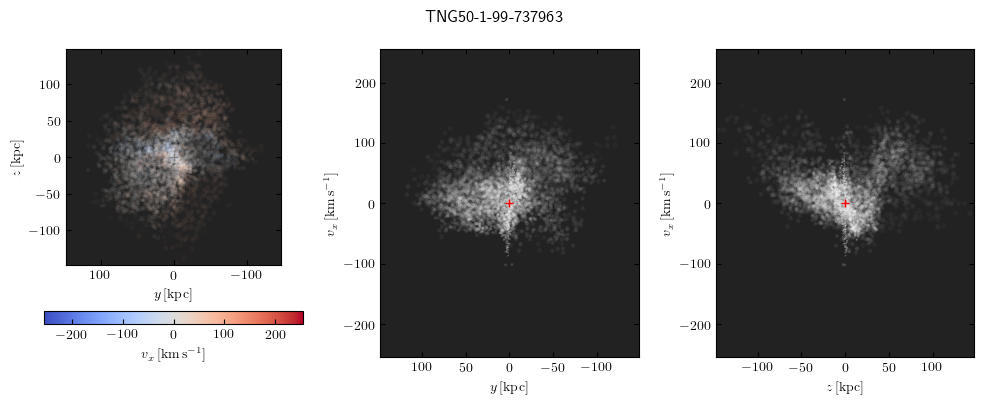

In [11]:
preview_fig_unrotated = source.preview(title=f"{simulation}-{snapshot}-{subhalo_id}")

We can also zoom in a bit to get a better view of the disc.

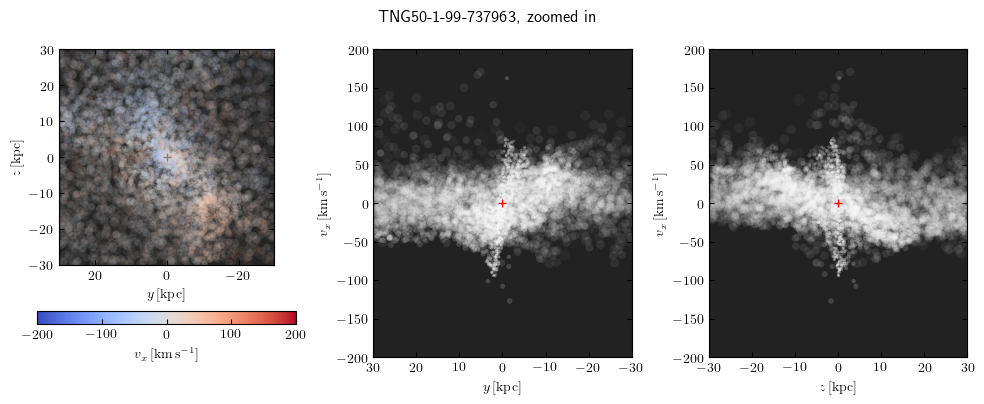

In [12]:
preview_fig_unrotated_zoom = source.preview(
    title=f"{simulation}-{snapshot}-{subhalo_id}, zoomed in",
    lim=30 * U.kpc,
    vlim=200 * U.km / U.s,
)

This seems to look ok, so let's proceed with setting up the rest of the MARTINI modules.

### BEAM

To match the observed data cube, we'll need to convolve with a similar beam. THINGS natural-weighted datacubes have spatial resolution of about 12 arcsec, so for this example we'll approximate the beam as a 12 arcsec circular Gaussian beam. Some data cube headers contain information about the beam (although this THINGS cube does not). When this is the case it might be a good idea to use the header information directly in initializing a MARTINI beam.

In [13]:
beam = GaussianBeam(
    bmaj=12.0 * U.arcsec,
    bmin=12.0 * U.arcsec,
)

### NOISE, SPECTRAL MODEL & SPH KERNEL

The observed data cube already contains noise that will be added to our mock observation when the cubes are combined, so we won't add our own. We'll use sensible choices for the ``spectral_model`` and ``sph_kernel``; these aren't the focus of this example so refer to the [documentation](https://martini.readthedocs.io/en/latest/) for details.

In [14]:
noise = None
spectral_model = GaussianSpectrum(sigma="thermal")
sph_kernel = CubicSplineKernel()

### MARTINI

Now set up the main MARTINI class:

In [15]:
M = Martini(
    source=source,
    datacube=datacube,
    beam=beam,
    noise=noise,
    spectral_model=spectral_model,
    sph_kernel=sph_kernel,
)

Source module contained 73179 particles with total HI mass of 4.81e+08 solMass.
Pruned particles that will not contribute to data cube, 30708 particles remaining with total HI mass of 4.76e+08 solMass.


This generates a message that some particles have been pruned from our source because they won't contribute to the data cube. The ``Martini`` class also provides a preview tool similar to the one provided by the source module, but this time the extent of the data cube is drawn on.

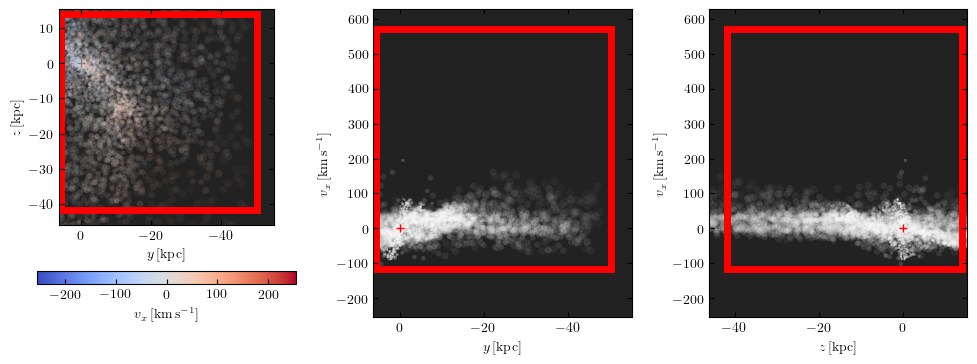

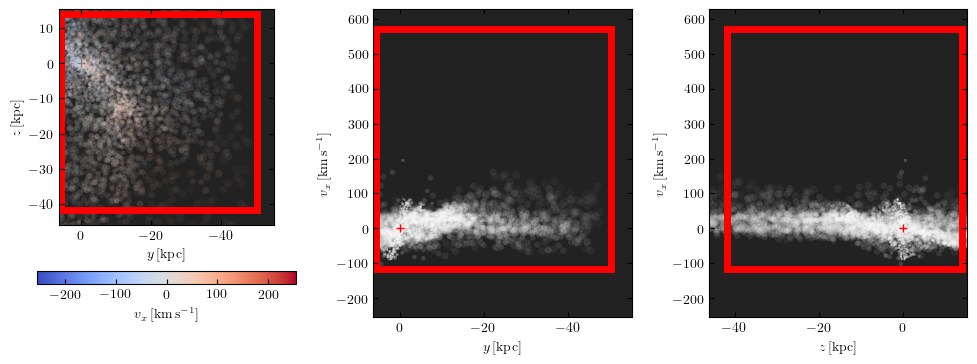

In [16]:
M.preview()

The reason that we got a message saying that some particles were removed is clear: our galaxy extends past the edge of the cube. This isn't a problem, perhaps this "galaxy" that wasn't the main target of the observation happened to straddle the boundary of the field of view.

Next we run the bulk of the work of inserting the source into the datacube and the convolution of the beam. On a single CPU the source insertion step could take quite a while (hours?), so running this in parallel is recommended if you have a multi-core CPU. Just edit the following cell specifying the number of cores that you wish to use. My 32-core setup runs the insertion in a couple of minutes.

In [17]:
ncpu = 16  # can set >1 if multiprocess is installed

By default a progress bar (provided by ``tqdm``) will be displayed. This can be a bit glitchy on notebooks, especially when running on multiple cores, you can disable it with ``M.insert_source_in_cube(progressbar=False)``.

The beam convolution step is relatively inexpensive.

We'll also set up the cell to skip the expensive calculation if it finds an output file in the working directory.

In [18]:
martini_cube_file = "sourceinjectiondemo.fits"
if not os.path.isfile(martini_cube_file):
    M.insert_source_in_cube(  # this could take a while, especially if using 1 cpu
        ncpu=ncpu,
        progressbar=False,
    )
    M.convolve_beam()
    M.write_fits(martini_cube_file)

### COMBINE CUBES

We now have two FITS files with exactly the same WCS. As mentioned above, the one possible difference is in the axis ordering, but this can be corrected by transposing the cube produced by MARTINI. The transpose below keeps the same axis ordering, but if we wanted to swap the 0th and 1st axes this could be edited to ``transpose((1, 0, 2, 3))``, or other permutations as needed. Remember that FITS cubes have the axis order "reversed" relative to the WCS numbering, so in the ``martini_cube`` defined in this cell the 0th axis is the Stokes' axis, 1st is Spectral, 2nd is Dec and 3rd is RA.

In [19]:
with fits.open("NGC_2841_NA_CUBE_THINGS.FITS") as fitsfile:
    ngc2841_header = fitsfile[0].header
    ngc2841_cube = fitsfile[0].data
with fits.open(martini_cube_file) as fitsfile:
    martini_header = fitsfile[0].header
    martini_cube = fitsfile[0].data.transpose((0, 1, 2, 3))  # this transpose: no effect

Before co-adding the data cubes, we can also check that the units match:

In [20]:
print(ngc2841_header["BUNIT"], martini_header["BUNIT"], sep="\n")

JY/BEAM
Jy beam-1


Before writing out a combined cube, let's quickly visualise the individual cubes and their combination. First we'll simply sum along the spectral axis (and the Stokes' axis) to obtain a quick "surface density" map.

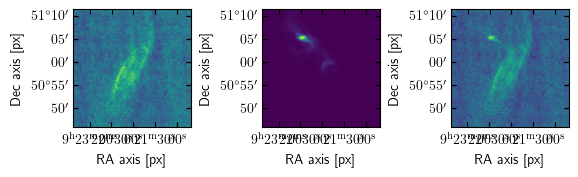

In [21]:
import matplotlib.pyplot as plt

fig, sps = plt.subplots(
    1,
    3,
    sharex=True,
    sharey=True,
    subplot_kw=dict(projection=wcs.WCS(ngc2841_header).celestial),
)
sps[0].imshow(ngc2841_cube.sum(axis=(0, 1)))
sps[1].imshow(martini_cube.sum(axis=(0, 1)))
sps[2].imshow((ngc2841_cube + martini_cube).sum(axis=(0, 1)))
for sp in sps:
    sp.set_xlabel("RA axis [px]")
    sp.set_ylabel("Dec axis [px]")
plt.subplots_adjust(wspace=0.6)

We can also sum along the RA (and Stokes') axis to get a quick "position velocity" diagram, albeit one along a fairly arbitrary direction.

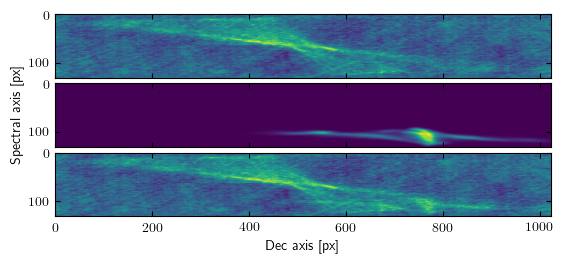

In [22]:
fig, sps = plt.subplots(3, 1, sharex=True, sharey=True)
sps[0].imshow((ngc2841_cube).sum(axis=(0, 3)))
sps[1].imshow((martini_cube).sum(axis=(0, 3)))
sps[2].imshow((ngc2841_cube + martini_cube).sum(axis=(0, 3)))
sps[1].set_ylabel("Spectral axis [px]")
sps[2].set_xlabel("Dec axis [px]")
fig.subplots_adjust(hspace=-0.7)

Finally let's write the summed cubes to a new FITS file. In this example we'll just copy in the header from the THINGS data cube directly, with the minor addition of a comment mentioning the addition of a simulated galaxy.

In [23]:
out_header = ngc2841_header.copy()
out_header.append(("COMMENT", "Simulated Illustis-TNG galaxy added with MARTINI."))
hdu = fits.PrimaryHDU(
    header=out_header,
    data=ngc2841_cube + martini_cube,
)
hdu.writeto(f"NGC_2841_AND_{simulation}_{snapshot}_{subhalo_id}.FITS", overwrite=True)